In [1]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

/home/jonathan/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [3]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [4]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [5]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, testX, testy

# Cargamos el Dataset
## Transformamos los datos de la serie de tiempo a aprendizaje supervisado

In [6]:
series = read_csv('/home/jonathan/tesis/7mo_avance/daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)

In [7]:
series.head(50)

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
1959-01-06,29
1959-01-07,45
1959-01-08,43
1959-01-09,38


In [8]:
data

array([[35., 32., 30., ..., 44., 29., 45.],
       [32., 30., 31., ..., 29., 45., 43.],
       [30., 31., 44., ..., 45., 43., 38.],
       ...,
       [40., 38., 44., ..., 37., 52., 48.],
       [38., 44., 34., ..., 52., 48., 55.],
       [44., 34., 37., ..., 48., 55., 50.]])

In [9]:
# evaluate
mae, y, yhat, testX, testy = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

>expected=42.0, predicted=45.6
>expected=53.0, predicted=43.2
>expected=39.0, predicted=41.7
>expected=40.0, predicted=38.5
>expected=38.0, predicted=42.9
>expected=44.0, predicted=48.5
>expected=34.0, predicted=42.5
>expected=37.0, predicted=36.6
>expected=52.0, predicted=37.9
>expected=48.0, predicted=41.8
>expected=55.0, predicted=43.7
>expected=50.0, predicted=45.0
MAE: 6.045


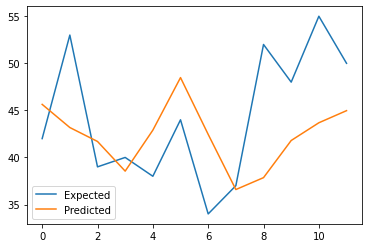

In [10]:
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [13]:
testX

array([44., 34., 37., 52., 48., 55.])